In [201]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)

def fig_panel_labels(axes, letters='ABCDEFGHIJKLMNOP', xcoord=-0.17, ycoord=0.92, panel_label_size=plt.rcParams[ 'axes.titlesize']*1.3):
    return [
        ax.annotate(letter, (xcoord, ycoord), xycoords='axes fraction', fontsize=panel_label_size)
        for ax, letter 
        in zip(axes.flat, letters)
    ]

## Definitions

- p: freq of η
- q: freq of H
- x: freq of A within η
- 1-x: freq of B within η
- y: freq of A within H
- 1-y: freq of B within H

## Recursion 

$$
x' = \frac{x \omega_A ((1-\eta) x + \eta) + (1-x) \omega_B (1-\eta) x}{\bar{\omega}_{\eta}} \\
y' = \frac{y \omega_A ((1-H) y + H) + (1-y) \omega_B (1-H) y}{\bar{\omega_H}} \\ 
p' = p \frac{x \omega_A + (1-x) \omega_B}{\bar{\omega}} \\
q' = 1-p' = q \frac{y \omega_A + (1-y) \omega_B}{\bar{\omega}} \\
\bar{\omega} = p \bar{\omega_{\eta}}  + q \bar{\omega_{H}} \\
\bar{\omega_{\eta}} = x \omega_A + (1-x) \omega_B \\
\bar{\omega_{H}} = y \omega_A + (1-y) \omega_B
$$

# Modifier numerical simulation

In [220]:
def recursion(p, x, y, W, w, e):
    if np.random.rand() > e:
        W, w = w, W
   
    xx = (x * W * ((1 - η) * x + η) + 
        (1 - x) * w * (1 - η) * x) / (x * W + (1 - x) * w) 
    yy = (y * W * ((1 - H) * y + H) + 
        (1 - y) * w * (1 - H) * y) / (y * W + (1 - y) * w)

    q = 1 - p

    pp = p * (x * W + (1 - x) * w)
    meanW = pp + q * (y * W +  (1 - y) * w)
    pp /= meanW

    return pp, xx, yy

In [232]:
η = η0 = 0.1
H = η/10
W = 1
w = 0.1

n = 1000000
p = np.array([0.999]*n)
x = np.array([0.1]*n)
y = np.array([0.1]*n)
rate = np.array([0.0]*n)
rate[0] = p[0] * η + (1 - p[0]) * H
e = 0
invasions = []

for t in range(1, n):
    W, w = w, W
    p[t], x[t], y[t] = recursion(
        p[t-1], x[t-1], y[t-1], W, w, e
    )
    rate[t] = p[t] * η + (1-p[t]) * H
    if p[t] > 0.999:
        p[t] = 0.999 # mutator locus mutation
    if p[t] < 0.001:
        p[t] = 1-p[t]
        print(H, end='')
        η, H = H, H/10
        x[t] = y[t]
        invasions.append(t)
        
q = 1 - p

0.010.0010.00011e-05

In [234]:
for i, inv in enumerate(invasions):
    print(i, η0/(10**(i+1)))

0 0.01
1 0.001
2 0.0001
3 1e-05


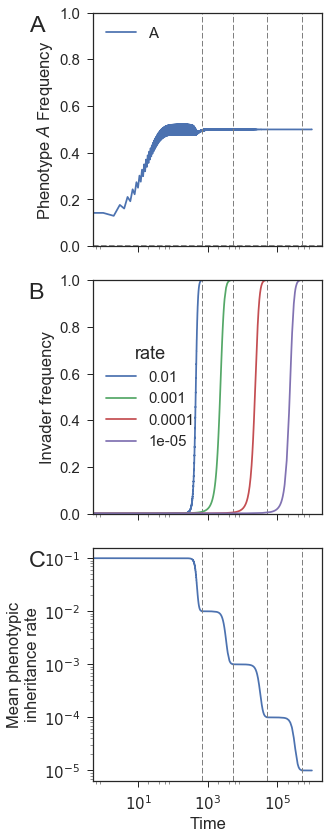

In [256]:
fig, axes = plt.subplots(3, 1, figsize=(5, 12), sharey=False, sharex=True)
axes[0].plot(p*x + q*y, label='A')
axes[0].axhline(e, ls='--', color='gray')
axes[2].plot(rate)
t = 0
for i, inv in enumerate(invasions):
    for j in range(3): axes[j].axvline(inv, ls='--', lw=1, color='gray')
    axes[1].plot(q[t:inv], label='{:.2g}'.format(η0/(10**(i+1))))
    t = inv
axes[0].set(ylim=(0,1), ylabel='Phenotype $A$ Frequency')
axes[0].legend()
axes[1].set(ylim=(0,1), ylabel='Invader frequency')
axes[1].legend(title='rate')
axes[2].set(ylabel='Mean phenotypic\ninheritance rate', yscale='log', xlabel='Time', xscale='log')

fig_panel_labels(axes, xcoord=-0.28)
fig.tight_layout()
η, H, p[-1], invasions

fig.savefig('../figures/A1B1_modifier_invasions.pdf')

# Modifier analysis

In [44]:
import sympy
sympy.init_printing()

In [45]:
x, s, η, H, ε = sympy.symbols('x s η H ε', real=True, positive=True)

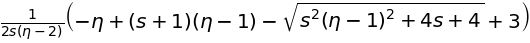

In [46]:
x_star = ((1 + s) * (1 - η) - (3 - η) + sympy.sqrt((1 - η)**2 * s**2 + 4 * (1 + s))) / (2 * (2 -  η) * s)
x_star = sympy.simplify(x_star)
x_star

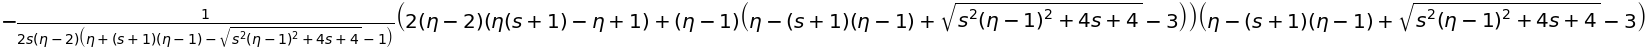

In [47]:
x_star_prime = x_star * (x_star * (1 - η) * s + η * (1 + s) + (1 - η)) / (1 + s * x_star)
x_star_prime = sympy.simplify(x_star_prime)
x_star_prime

In [48]:
x_star_eta_0 = 1/(4*s) * (s + (s+2) -2)
x_star_eta_0

In [50]:
x_star = x_star_eta_0

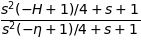

In [53]:
λ = (1 + s + s**2 * (1 - H) * x_star * (1 - x_star)) / (1 + s + s**2 * (1 - η) * x_star * (1 - x_star))
λ

In [127]:
# Mean fitness

s_ = np.linspace(0, 1, 100)
η_ = np.linspace(0, 1, 100).reshape(100, 1)

ww = (s_ * (1 - η_) - 2 + np.sqrt((1 - η_)**2 * s_**2 + 4*(1 + s_))) / (2 * (2 - η_))

In [114]:
λ_ = np.array(
    [
        [
            float(λ.subs({η: 0, H: H_, s: s_})) 
            for s_ in np.linspace(0, 1, 100)
        ] 
        for H_ in np.linspace(0, 1 , 100)
    ]
)

λ_.min(), λ_.max(), (λ_ >= 1).all(), (λ_ <= 1).all()

(0.88888888888888884, 1.0, False, True)

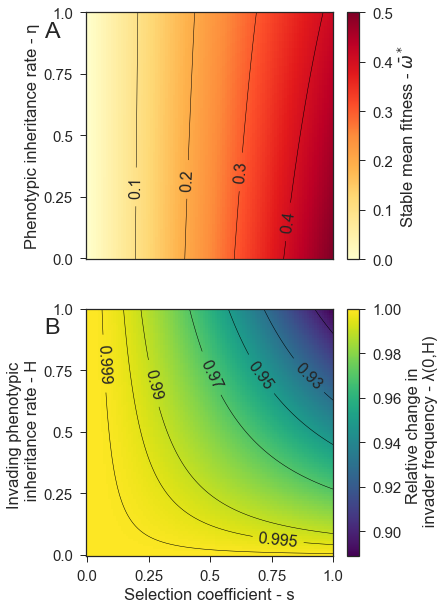

In [219]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))

ax = axes[0]
extent = (-0.5, ww.shape[0], -0.5, ww.shape[1])
im = ax.imshow(ww, cmap='YlOrRd', origin=(0,0), aspect=1, extent=extent, interpolation='none')
cntr = ax.contour(ww, levels=np.linspace(0.1, 0.4, 4), aspect=1, linewidths=0.5, colors='k', extent=extent)
ax.clabel(cntr, fmt=lambda x: '{:.1f}'.format(x), fontsize=16, colors="#252525")
cb1 = plt.colorbar(im, ax=ax, fraction=0.045, label=r'Stable mean fitness - $\bar{\omega}^*$')
# ax.set_xlabel('Selection coefficient - s')
ylabel1 = ax.set_ylabel(r'Phenotypic inheritance rate - η')
ax.set_xticks([])
# ax.set_xticklabels(np.linspace(0, 1, 5))
ax.set_yticks(np.linspace(0, 100, 5))
ax.set_yticklabels(np.linspace(0, 1, 5))

ax = axes[1]
extent = (-0.5, λ_.shape[0], -0.5, λ_.shape[1])
im = ax.imshow(λ_, cmap='viridis', origin=(0,0), aspect=1, extent=extent, interpolation='none')
cntr = ax.contour(λ_, levels=[0.9, 0.93, 0.95, 0.97, 0.99, 0.995, 0.999], aspect=1, linewidths=0.5, colors='k', extent=extent)
ax.clabel(cntr, fmt=lambda x: '{:.3g}'.format(x),fontsize=16, colors="#252525")
# ax.set_xlabel('Selection coefficient - s')
ylabel2 = ax.set_ylabel('Invading phenotypic \n inheritance rate - H')
cb2 = plt.colorbar(im, ax=ax, fraction=0.045, label="Relative change in \n invader frequency - λ(0,H)")
ax.set_xticks(np.linspace(0, 100, 5))
ax.set_xticklabels(np.linspace(0, 1, 5))
ax.set_yticks(np.linspace(0, 100, 5))
ax.set_yticklabels(np.linspace(0, 1, 5))

axes[1].set_xlabel('Selection coefficient - s')
fig_panel_labels(axes, ycoord=0.9)
# fig.tight_layout()

txt = [ylabel1, ylabel2]
fig.savefig('../figures/A1B1_EGS_eta_0.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
# txt